In [1]:
import numpy as np
import pandas as pd
import torch
import pickle
from itertools import chain
from collections import Counter
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
from transformers import DistilBertModel, DistilBertConfig

# specify GPU
device = torch.device("cpu")

In [2]:
pickle_in = open("../data/processed/dataBOW.pkl", "rb")
data1 = pickle.load(pickle_in)

In [ ]:
pickle_in = open("../data/processed/dataAZ_withMeasurements.pkl", "rb")
data2 = pickle.load(pickle_in)
data = {**data1, **data2}          

In [3]:
data = data1

In [4]:
# Undict data
data = list(chain.from_iterable(data.values()))

In [5]:
len(data)

14426

In [6]:
# create DataFrame using data
df = pd.DataFrame(data, columns =['label', 'text'])

In [7]:
# split train dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'], 
                                                                    random_state=2021, 
                                                                    test_size=0.2, 
                                                                    stratify=df['label'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2021, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

<AxesSubplot:>

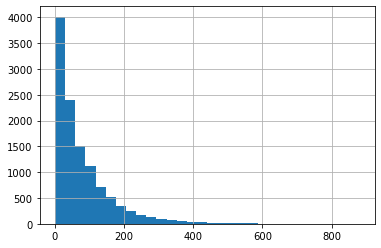

In [8]:
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [9]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 512,
    padding=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 512,
    padding=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 512,
    padding=True,
    truncation=True
)

In [11]:
## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [12]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 4

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [13]:
# unfreeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [14]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):
        
        super(BERT_Arch, self).__init__()
        
        self.bert = bert 
      
        # dropout layer
        self.dropout = nn.Dropout(0.1)

        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768, 512)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512, 2)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

        #pass the inputs to the model BERT  
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
        
        #pass the inputs to the model DistilBERT  
        #cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
        #cls_hs = cls_hs[0]
        
        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)

        # apply softmax activation
        x = self.softmax(x)

        return x

In [15]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [16]:
# Testing, Deactivate dropout layer
model.eval()
# Push a dataset trough the mode
BatchTest = next(iter(train_dataloader))

# push the batch to gpu
batch = [r.to(device) for r in BatchTest]
sent_id, mask, labels = batch

# Push the data trough the model
preds = model(sent_id, mask)
preds

tensor([[-0.6841, -0.7022],
        [-0.7082, -0.6784],
        [-0.7223, -0.6649],
        [-0.6908, -0.6955]], grad_fn=<LogSoftmaxBackward>)

In [18]:
labels

tensor([0, 0, 0, 0])

In [32]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-5)          # learning rate was -5

In [33]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print("Class Weights:",class_weights)

Class Weights: [0.5671319  4.22401171]


In [34]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights, dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 2

In [35]:
# function to train the model
def train():
  
    model.train()

    total_loss, total_accuracy = 0, 0

    # empty list to save model predictions
    total_preds=[]

    # iterate over batches
    for step, batch in enumerate(train_dataloader):
    
        # progress update after every 50 batches.
        if step % 4 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        # push the batch to gpu
        batch = [r.to(device) for r in batch]

        sent_id, mask, labels = batch

        # clear previously calculated gradients 
        model.zero_grad()        

        # get model predictions for the current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()

        # append the model predictions
        total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)

    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds

In [36]:
# function for evaluating the model
def evaluate():
  
    print("\nEvaluating...")

    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step, batch in enumerate(val_dataloader):
    
        # Progress update every 50 batches.
        if step % 4 == 0 and not step == 0:
      
            # Calculate elapsed time in minutes.
            #elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():

            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader) 

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [37]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.6f}')
    print(f'Validation Loss: {valid_loss:.6f}')


 Epoch 1 / 2
  Batch     4  of  2,885.
  Batch     8  of  2,885.
  Batch    12  of  2,885.
  Batch    16  of  2,885.
  Batch    20  of  2,885.
  Batch    24  of  2,885.
  Batch    28  of  2,885.
  Batch    32  of  2,885.
  Batch    36  of  2,885.
  Batch    40  of  2,885.
  Batch    44  of  2,885.
  Batch    48  of  2,885.
  Batch    52  of  2,885.
  Batch    56  of  2,885.
  Batch    60  of  2,885.
  Batch    64  of  2,885.
  Batch    68  of  2,885.
  Batch    72  of  2,885.
  Batch    76  of  2,885.
  Batch    80  of  2,885.
  Batch    84  of  2,885.
  Batch    88  of  2,885.
  Batch    92  of  2,885.
  Batch    96  of  2,885.
  Batch   100  of  2,885.
  Batch   104  of  2,885.
  Batch   108  of  2,885.
  Batch   112  of  2,885.


KeyboardInterrupt: 

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

In [ ]:
len(test_seq)

In [ ]:
# Test amount

# get predictions for test data
with torch.no_grad():
    preds = model(test_seq[0:50].to(device), test_mask[0:50].to(device))
    preds = preds.detach().cpu().numpy()

In [ ]:
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y[0:50], preds))